# Broadband polarizer assisted by anisotropic metamaterial

Silicon photonic polarizers are specialized optical devices designed to filter, control, and manipulate the polarization state of light in integrated photonic circuits. Comprising carefully engineered silicon waveguide structures, these polarizers play a crucial role in ensuring the efficient and reliable operation of various optical communication and sensing systems. Over the years, various silicon photonic polarizer designs have been proposed. However, most designs suffer from a narrow working bandwidth or a large device footprint. 

A polarizer design demonstrated by `Hongnan Xu, Daoxin Dai, and Yaocheng Shi, "Anisotropic metamaterial-assisted all-silicon polarizer with 415-nm bandwidth," *Photon. Res.* 7, 1432-1439 (2019)`, [DOI: 10.1364/PRJ.7.001432](https://doi.org/10.1364/PRJ.7.001432) utilizes anisotropic subwavelength grating (SWG) metamaterial cladding to a 180 degree waveguide bend. This polarizer design preserves the TE mode and filters out TM mode in a broad wavelength range of 400 nm. The footprint of the device is also more compact than many of the previous designs.

<img src="img/swg_polarizer.png" width="500" alt="Schematic of the polarizer">

For more integrated photonic examples such as the [8-Channel mode and polarization de-multiplexer](https://www.flexcompute.com/tidy3d/examples/notebooks/8ChannelDemultiplexer/), the [broadband bi-level taper polarization rotator-splitter](https://www.flexcompute.com/tidy3d/examples/notebooks/BilevelPSR/), and the [broadband directional coupler](https://www.flexcompute.com/tidy3d/examples/notebooks/BroadbandDirectionalCoupler/), please visit our [examples page](https://www.flexcompute.com/tidy3d/examples/).

If you are new to the finite-difference time-domain (FDTD) method, we highly recommend going through our [FDTD101](https://www.flexcompute.com/fdtd101/) tutorials. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import gdstk
import tidy3d as td
import tidy3d.web as web

## Effective Anisotropic Refractive Index Tensor of the SWG

For this device, first we are going to make a regular 180 degree waveguide bend. In the bending region, we are going to add an SWG metamaterial parallel to the bend. The SWG metamaterial acts as an effective medium with an anisotropic refractive index tensor. The ordinary and extraordinary refractive indices are given by the well known Rytov's approximation: $1/n_e^2=f/n_{si}^2+(1-f)/n_{air}^2$ and $n_o^2=fn_{si}^2+(1-f)n_{air}^2$, where $f$ is the duty cycle of the SWG. We can investigate how the effective indices vary with $f$.

From the result, we notice that $n_0$ is much larger than $n_e$ when $f$ is not close to 0 or 1. Since the TE waveguide mode has the electric field primarily in the extraordinary direction while the TM mode has the electric field primarily in the ordinary direction, they will feel very different refractive index in the SWG metamaterial. For TE mode, the refractive index is much lower than $n_{si}$ so it should stay guided inside the waveguide. For TM mode, on the other hand, the effective refractive index is close to $n_{si}$ so it will be guided into the SWG metamaterial region and radiates out. This way, the waveguide bend together with the SWG metamaterial functions as a polarizer that passes TE mode and suppresses TM mode. 

For a more detailed discussion, please refer to the [reference](https://doi.org/10.1364/PRJ.7.001432).

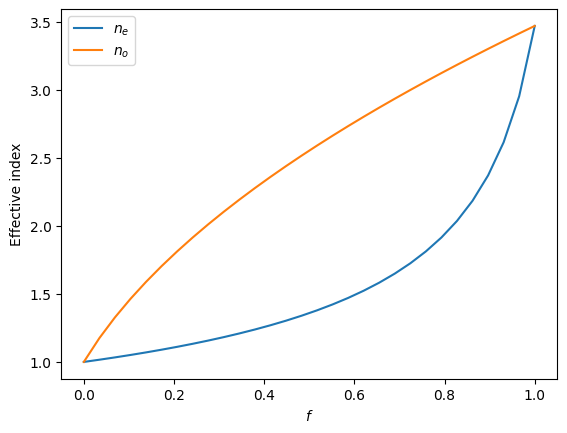

In [2]:
n_si = 3.47

f = np.linspace(0, 1, 30)
n_e = np.sqrt(1 / (f / n_si**2 + (1 - f)))
n_o = np.sqrt(f * n_si**2 + (1 - f))
plt.plot(f, n_e, label="$n_e$")
plt.plot(f, n_o, label="$n_o$")
plt.xlabel("$f$")
plt.ylabel("Effective index")
plt.legend()
plt.show()

## Structure Setup 

The simulation wavelength range is from 1260 nm to 1675 nm. 

In [3]:
lda_min = 1.26  # minimal wavelength
lda_max = 1.675  # maximal wavelength
lda0 = (lda_min + lda_max) / 2  # central wavelength
freqs = np.linspace(td.C_0 / lda_max, td.C_0 / lda_min, 301)  # frequency range
freq0 = td.C_0 / lda0  # central frequency

fwidth = 0.4 * (td.C_0 / lda_min - td.C_0 / lda_max)  # width of the frequency range of the source

Next, we define the media used in the simulation. Since the simulation is very broadband, it is better to use dispersive media. We can use the crystalline silicon and silicon dioxide from Tidy3D's built-in [material library](../api/material_library.html).

In [4]:
si = td.material_library["cSi"]["Li1993_293K"]
sio2 = td.material_library["SiO2"]["Horiba"]

The silicon layer has a thickness of 250 nm. To stay at single mode operation, the waveguide width is chosen to be 360 nm. The design parameters such as waveguide bend radius, period of the SWG, maximal and minimal duty cycles, and the number of SWG layers need to be optimized for the design. This is explored in the [reference](https://doi.org/10.1364/PRJ.7.001432). Here we report the optimized parameters. 

In [5]:
h_si = 0.25  # silicon layer thickness
w_wg = 0.36  # waveguide width
R_0 = 3.5  # radius of the waveguide bend
p = 0.3  # period of the SWG
f_M = 0.75  # maximal duty cycle
f_m = 0.2  # minimal duty cycle
N = 9  # number of SWG layers
inf_eff = 1e3  # effective infinity

The radius of the $i$-th SWG layer is given by $R_i = R_0 + w_wg/2 + p(i-1/2)$ and the duty cycle of the layer is also given by a linear ramping $f_i=f_M+(f_m-f_M)(i-1)/(N-1)$. The width of the waveguide in each SWG layer is thus given by $pf_i$.

In [6]:
R_is = [R_0 + w_wg / 2 + p * (i - 0.5) for i in range(1, N + 1)]  # radius of each SWG layer
f_is = [
    f_M + (f_m - f_M) * (i - 1) / (N - 1) for i in range(1, N + 1)
]  # duty cycle of each SWG layer
w_is = [p * f for f in f_is]  # waveguide width of each SWG layer

# insert the circular waveguide band into the list
R_is.insert(0, R_0)
w_is.insert(0, w_wg)

With all the parameters determined, we can set up the geometries. One easy way is to make use of the `gdstk` library as demonstrated below.

In [7]:
cell = gdstk.Cell("SWG")  # define a gds cell

# define a path of each swg layer
for R_i, w_i in zip(R_is, w_is):
    points_x = np.linspace(-R_i, R_i, 1001)  # x coordinates of the waveguide in the swg layer
    points_y = np.sqrt(R_i**2 - points_x**2)  # y coordinates

    # if it's the innermost waveguide bend, add two points to the coordinates to include the straight waveguides
    if R_i == R_0:
        points_x = np.insert(points_x, 0, -R_0)
        points_y = np.insert(points_y, 0, -inf_eff)
        points_x = np.append(points_x, R_0)
        points_y = np.append(points_y, -inf_eff)

    points = points_x + 1j * points_y

    # add the path to the cell
    cell.add(gdstk.FlexPath(points, w_i, layer=1, datatype=0))

In [8]:
# define geometry from the paths in the cell
device_geo = td.PolySlab.from_gds(
    cell,
    gds_layer=1,
    axis=2,
    slab_bounds=(0, h_si),
)

To make sure the geometries are defined correctly, we can plot them first. From the plot, it indeed looks like the correct device.

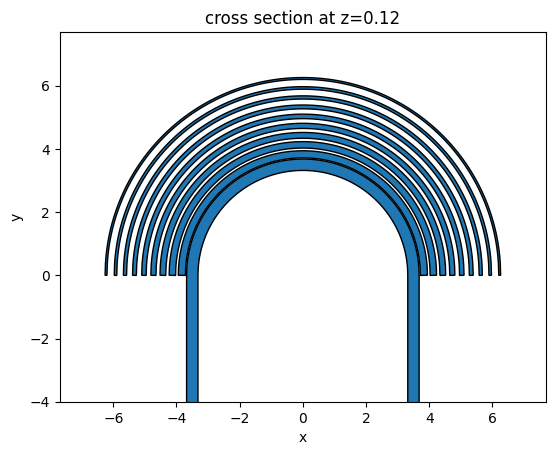

In [9]:
l_straight = 4
pad = lda0

fig, ax = plt.subplots()
for geo in device_geo:
    geo.plot(z=h_si / 2, ax=ax)
ax.set_ylim(-l_straight, R_is[-1] + pad)
ax.set_xlim(-R_is[-1] - pad, R_is[-1] + pad)
plt.show()

Lastly, we define Tidy3D [Structures](../api/_autosummary/tidy3d.Structure.html) from the geometries. A silicon dioxide substrate structure is also defined.

In [10]:
device_structure = [td.Structure(geometry=geo, medium=si) for geo in device_geo]
substrate = td.Structure(
    geometry=td.Box.from_bounds(rmin=(-inf_eff, -inf_eff, -inf_eff), rmax=(inf_eff, inf_eff, 0)),
    medium=sio2,
)

## TE Input Simulation

To fully characterize the device performance, we need to simulate two cases: TE input and TM input. First, let's set up the simulation for the TE input. A [ModeSource](../api/_autosummary/tidy3d.ModeSource.html) is defined to inject the TE mode at the input waveguide by setting `mode_index=0`. Note that since the simulation is quite broadband, we use a broadband source by setting `num_freqs = 10`, which accounts for the frequency-dependent mode profile.

In [11]:
# define a mode source that injects the fundamental te mode
mode_spec = td.ModeSpec(num_modes=2, target_neff=n_si)
mode_source = td.ModeSource(
    center=(-R_0, -l_straight / 2, h_si / 2),
    size=(4 * w_wg, 0, 4 * h_si),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="+",
    mode_spec=mode_spec,
    mode_index=0,
    num_freqs=10,
)

# define a mode monitor to measure the transmission of the mode
mode_monitor = td.ModeMonitor(
    center=(R_0, -l_straight * 0.9, h_si / 2),
    size=mode_source.size,
    freqs=freqs,
    mode_spec=mode_spec,
    name="mode",
)

lda_field = 1.55  # frequency at which field is monitored

# define a field monitor to visualize mode propagation
field_monitor = td.FieldMonitor(
    center=(0, 0, h_si / 2), size=(td.inf, td.inf, 0), freqs=[td.C_0 / lda_field], name="field"
)

Define a Tidy3D [Simulation](../api/_autosummary/tidy3d.Simulation.html).

In [12]:
# simulation domain size
Lx = 2 * (R_is[-1] + pad)
Ly = l_straight + R_is[-1] + pad
Lz = 8 * h_si

run_time = 1e-12  # simulation run time

# define a simulation
sim_te = td.Simulation(
    center=(0, 0.5 * (R_is[-1] + pad - l_straight), 0),
    size=(Lx, Ly, Lz),
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=20, wavelength=lda0),
    structures=device_structure + [substrate],
    sources=[mode_source],
    monitors=[mode_monitor, field_monitor],
    run_time=run_time,
)

00:31:10 PST WARNING: A structure has a nonzero dimension along axis y, which is
             however too small compared to the generated mesh step along that   
             direction. This could produce unpredictable results. We recommend  
             increasing the resolution, or adding a mesh override structure to  
             ensure that all geometries are at least one pixel thick along all  
             dimensions.                                                        

             WARNING: Suppressed 7 WARNING messages.                            

Visualize the simulation setup before submitting it to the server.

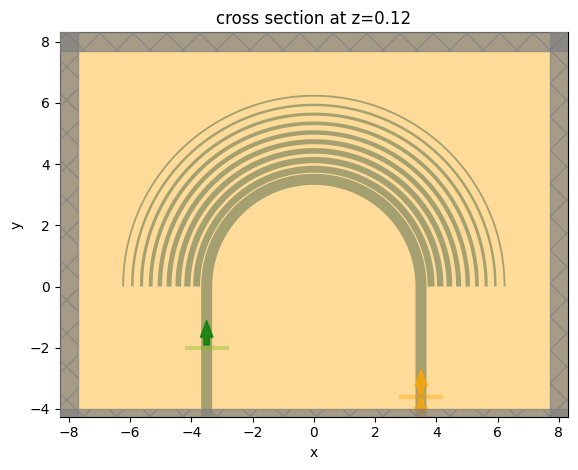

In [13]:
sim_te.plot(z=h_si / 2)
plt.show()

Submit the simulation to the server.

In [14]:
job = web.Job(simulation=sim_te, task_name="TE_mode")
sim_data_te = job.run(path="data/simulation_data.hdf5")

             Created task 'TE_mode' with task_id                                
             'fdve-06e6dfad-6f74-4c73-874d-6a0978443251' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=206090;https://tidy3d.simulation.cloud/workbench?taskId=fdve-06e6dfad-6f74-4c73-874d-6a0978443251\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=450334;https://tidy3d.simulation.cloud/workbench?taskId=fdve-06e6dfad-6f74-4c73-874d-6a0978443251\taskId]8;;\]8;id=206090;https://tidy3d.simulation.cloud/workbench?taskId=fdve-06e6dfad-6f74-4c73-874d-6a0978443251\=]8;;\]8;id=396450;https://tidy3d.simulation.cloud/workbench?taskId=fdve-06e6dfad-6f74-4c73-874d-6a0978443251\fdve]8;;\]8;id=206090;https://tidy3d.simulation.cloud/workbench?taskId=fdve-06e6dfad-6f74-4c73-874d-6a0978443251\-06e6dfad-6f7]8;;\
             ]8;id=206090;https://tidy3d.simulation.cloud/workbench?taskId=fdve-06e6dfad-6f74-4c73-874d-6a0978443251\4-4c73-874d-6a0978443251']8;;\.

Output()

00:31:12 PST status = queued

Output()

00:31:16 PST status = preprocess

00:31:19 PST Maximum FlexCredit cost: 0.397. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

00:33:32 PST early shutoff detected at 56%, exiting.

             status = postprocess

Output()

00:33:35 PST status = success

             View simulation result at                                          
             ]8;id=922621;https://tidy3d.simulation.cloud/workbench?taskId=fdve-06e6dfad-6f74-4c73-874d-6a0978443251\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=7760;https://tidy3d.simulation.cloud/workbench?taskId=fdve-06e6dfad-6f74-4c73-874d-6a0978443251\taskId]8;;\]8;id=922621;https://tidy3d.simulation.cloud/workbench?taskId=fdve-06e6dfad-6f74-4c73-874d-6a0978443251\=]8;;\]8;id=940787;https://tidy3d.simulation.cloud/workbench?taskId=fdve-06e6dfad-6f74-4c73-874d-6a0978443251\fdve]8;;\]8;id=922621;https://tidy3d.simulation.cloud/workbench?taskId=fdve-06e6dfad-6f74-4c73-874d-6a0978443251\-06e6dfad-6f7]8;;\
             ]8;id=922621;https://tidy3d.simulation.cloud/workbench?taskId=fdve-06e6dfad-6f74-4c73-874d-6a0978443251\4-4c73-874d-6a0978443251']8;;\.

Output()

00:33:36 PST loading simulation from data/simulation_data.hdf5

             WARNING: A structure has a nonzero dimension along axis y, which is
             however too small compared to the generated mesh step along that   
             direction. This could produce unpredictable results. We recommend  
             increasing the resolution, or adding a mesh override structure to  
             ensure that all geometries are at least one pixel thick along all  
             dimensions.                                                        

             WARNING: Suppressed 7 WARNING messages.                            

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

## TM Input Simulation

Before analyzing the simulation result for the TE input case, let's run the TM input case first. To have a TM input simulation, we only need to update the `mode_index` to `1` in the [ModeSource](../api/_autosummary/tidy3d.ModeSource.html). This can be done easily by copying the previous simulation.

In [15]:
mode_source = mode_source.copy(
    update={"mode_index": 1}
)  # copy the mode source and update mode_index
sim_tm = sim_te.copy(update={"sources": [mode_source]})  # copy the simulation and update the source

job = web.Job(simulation=sim_tm, task_name="TM_mode")
sim_data_tm = job.run(path="data/simulation_data.hdf5")

00:33:39 PST WARNING: A structure has a nonzero dimension along axis y, which is
             however too small compared to the generated mesh step along that   
             direction. This could produce unpredictable results. We recommend  
             increasing the resolution, or adding a mesh override structure to  
             ensure that all geometries are at least one pixel thick along all  
             dimensions.                                                        

             WARNING: Suppressed 7 WARNING messages.                            

             Created task 'TM_mode' with task_id                                
             'fdve-2bd238d8-9b62-4542-9769-8f251cbed102' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=634758;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2bd238d8-9b62-4542-9769-8f251cbed102\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=601956;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2bd238d8-9b62-4542-9769-8f251cbed102\taskId]8;;\]8;id=634758;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2bd238d8-9b62-4542-9769-8f251cbed102\=]8;;\]8;id=183961;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2bd238d8-9b62-4542-9769-8f251cbed102\fdve]8;;\]8;id=634758;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2bd238d8-9b62-4542-9769-8f251cbed102\-2bd238d8-9b6]8;;\
             ]8;id=634758;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2bd238d8-9b62-4542-9769-8f251cbed102\2-4542-9769-8f251cbed102']8;;\.

Output()

00:33:41 PST status = queued

Output()

00:33:44 PST status = preprocess

00:33:47 PST Maximum FlexCredit cost: 0.397. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

00:36:01 PST early shutoff detected at 72%, exiting.

             status = postprocess

Output()

00:36:03 PST status = success

             View simulation result at                                          
             ]8;id=570057;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2bd238d8-9b62-4542-9769-8f251cbed102\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=858311;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2bd238d8-9b62-4542-9769-8f251cbed102\taskId]8;;\]8;id=570057;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2bd238d8-9b62-4542-9769-8f251cbed102\=]8;;\]8;id=772457;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2bd238d8-9b62-4542-9769-8f251cbed102\fdve]8;;\]8;id=570057;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2bd238d8-9b62-4542-9769-8f251cbed102\-2bd238d8-9b6]8;;\
             ]8;id=570057;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2bd238d8-9b62-4542-9769-8f251cbed102\2-4542-9769-8f251cbed102']8;;\.

Output()

00:36:05 PST loading simulation from data/simulation_data.hdf5

             WARNING: A structure has a nonzero dimension along axis y, which is
             however too small compared to the generated mesh step along that   
             direction. This could produce unpredictable results. We recommend  
             increasing the resolution, or adding a mesh override structure to  
             ensure that all geometries are at least one pixel thick along all  
             dimensions.                                                        

             WARNING: Suppressed 7 WARNING messages.                            

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

## Result Analysis

Now that both simulations are complete, let's visualize the results. First, we plot the transmission spectra. We see that in the TE input, transmission is close to 0 dB while in the TM input case, transmission is below -20 dB. This is the desirable outcome for a polarizer.

00:36:07 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

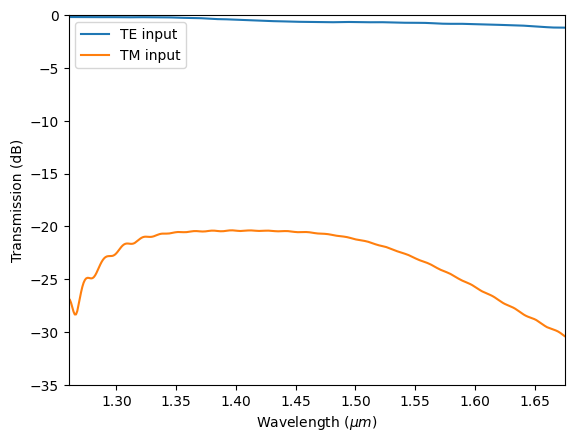

In [16]:
amp_te = sim_data_te["mode"].amps.sel(mode_index=0, direction="-")
T_te = np.abs(amp_te) ** 2

amp_tm = sim_data_tm["mode"].amps.sel(mode_index=1, direction="-")
T_tm = np.abs(amp_tm) ** 2

plt.plot(td.C_0 / freqs, 10 * np.log10(T_te), label="TE input")
plt.plot(td.C_0 / freqs, 10 * np.log10(T_tm), label="TM input")
plt.xlabel("Wavelength ($\mu m$)")
plt.ylabel("Transmission (dB)")
plt.ylim(-35, 0)
plt.xlim(lda_min, lda_max)
plt.legend()
plt.show()

We go on to plot the field distributions at 1550 nm in the two simulations. The TE mode (left plot) stays guided inside the waveguide bend and thus the transmission is high. The TM mode (right plot), on the other hand, is leaked into the SWG metamaterial region and radiates to free space eventually, leading to a low transmission.

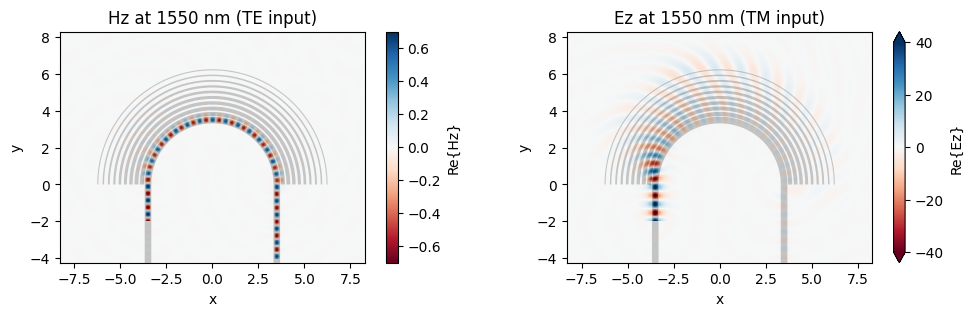

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
sim_data_te.plot_field(field_monitor_name="field", field_name="Hz", vmin=-0.7, vmax=0.7, ax=ax1)
sim_data_tm.plot_field(field_monitor_name="field", field_name="Ez", vmin=-40, vmax=40, ax=ax2)
ax1.set_title("Hz at 1550 nm (TE input)")
ax2.set_title("Ez at 1550 nm (TM input)")
plt.show()

## Reference Simulations without SWG

As a comparison, we can run a baseline reference and simulate the same waveguide bend without the SWG metamaterial cladding. We only need to copy the previous simulations and update the structure such that they don't contain the SWG. 

To further speed up the simulation, we put the TE and TM input cases into a batch and run them on the server simultaneously. 

In [18]:
# copy previous simulations and update the structures
sim_te_ref = sim_te.copy(update={"structures": [device_structure[0], substrate]})
sim_tm_ref = sim_tm.copy(update={"structures": [device_structure[0], substrate]})

# make a batch and run it
sims = {
    "TE": sim_te_ref,
    "TM": sim_tm_ref,
}
batch = web.Batch(simulations=sims, verbose=True)
batch_results = batch.run(path_dir="data")

00:36:10 PST Created task 'TE' with task_id                                     
             'fdve-0a28de80-4acc-4cdc-b09c-d13c2df03615' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=324978;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0a28de80-4acc-4cdc-b09c-d13c2df03615\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=306709;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0a28de80-4acc-4cdc-b09c-d13c2df03615\taskId]8;;\]8;id=324978;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0a28de80-4acc-4cdc-b09c-d13c2df03615\=]8;;\]8;id=480752;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0a28de80-4acc-4cdc-b09c-d13c2df03615\fdve]8;;\]8;id=324978;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0a28de80-4acc-4cdc-b09c-d13c2df03615\-0a28de80-4ac]8;;\
             ]8;id=324978;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0a28de80-4acc-4cdc-b09c-d13c2df03615\c-4cdc-b09c-d13c2df03615']8;;\.

Output()

             Created task 'TM' with task_id                                     
             'fdve-d3d5f0f7-2993-4c50-8c05-3d96089bcaf1' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=364766;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d3d5f0f7-2993-4c50-8c05-3d96089bcaf1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=45120;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d3d5f0f7-2993-4c50-8c05-3d96089bcaf1\taskId]8;;\]8;id=364766;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d3d5f0f7-2993-4c50-8c05-3d96089bcaf1\=]8;;\]8;id=638364;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d3d5f0f7-2993-4c50-8c05-3d96089bcaf1\fdve]8;;\]8;id=364766;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d3d5f0f7-2993-4c50-8c05-3d96089bcaf1\-d3d5f0f7-299]8;;\
             ]8;id=364766;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d3d5f0f7-2993-4c50-8c05-3d96089bcaf1\3-4c50-8c05-3d96089bcaf1']8;;\.

Output()

00:36:12 PST Started working on Batch.

00:36:13 PST Maximum FlexCredit cost: 0.482 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

00:39:24 PST Batch complete.

Lastly, we plot the same results. Without SWG, we see that both the TE and TM mode transmissions are high. Adding the SWG indeed couples the TM mode out of the waveguide.

Output()

00:39:28 PST loading simulation from                                            
             data/fdve-0a28de80-4acc-4cdc-b09c-d13c2df03615.hdf5

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

Output()

00:39:30 PST loading simulation from                                            
             data/fdve-d3d5f0f7-2993-4c50-8c05-3d96089bcaf1.hdf5

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

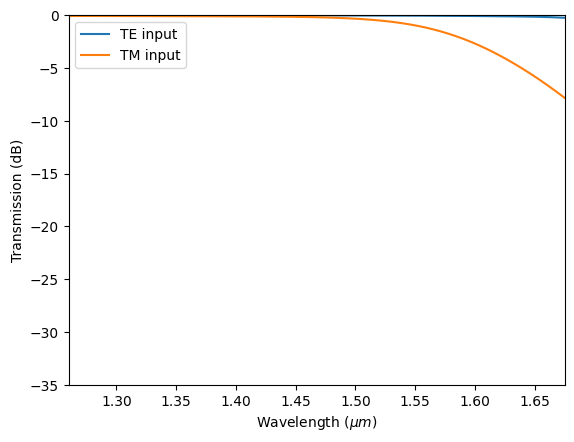

In [19]:
amp_te_ref = batch_results["TE"]["mode"].amps.sel(mode_index=0, direction="-")
T_te_ref = np.abs(amp_te_ref) ** 2

amp_tm_ref = batch_results["TM"]["mode"].amps.sel(mode_index=1, direction="-")
T_tm_ref = np.abs(amp_tm_ref) ** 2

plt.plot(td.C_0 / freqs, 10 * np.log10(T_te_ref), label="TE input")
plt.plot(td.C_0 / freqs, 10 * np.log10(T_tm_ref), label="TM input")
plt.xlabel("Wavelength ($\mu m$)")
plt.ylabel("Transmission (dB)")
plt.ylim(-35, 0)
plt.xlim(lda_min, lda_max)
plt.legend()
plt.show()

             loading simulation from                                            
             data/fdve-0a28de80-4acc-4cdc-b09c-d13c2df03615.hdf5

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

00:39:31 PST loading simulation from                                            
             data/fdve-d3d5f0f7-2993-4c50-8c05-3d96089bcaf1.hdf5

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

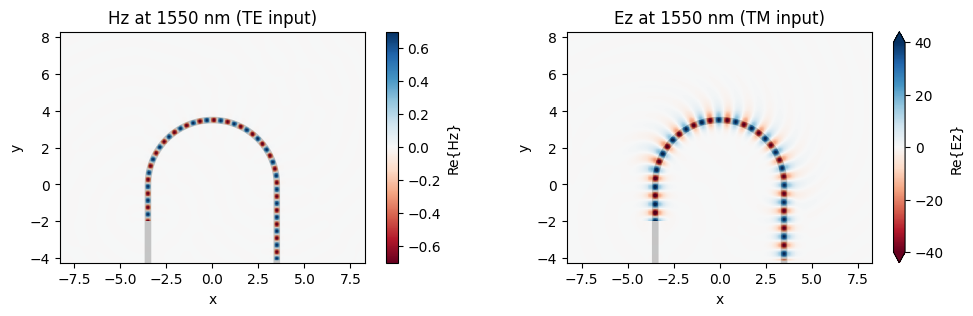

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
batch_results["TE"].plot_field(
    field_monitor_name="field", field_name="Hz", vmin=-0.7, vmax=0.7, ax=ax1
)
batch_results["TM"].plot_field(
    field_monitor_name="field", field_name="Ez", vmin=-40, vmax=40, ax=ax2
)
ax1.set_title("Hz at 1550 nm (TE input)")
ax2.set_title("Ez at 1550 nm (TM input)")
plt.show()